In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from netam import shmoof, noof

In [2]:
full_shmoof_df = pd.read_csv("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", index_col=0).reset_index(drop=True)

full_shmoof_df = full_shmoof_df.sample(5000)

train_df = full_shmoof_df.sample(frac=0.8)
val_df = full_shmoof_df.drop(train_df.index)

In [3]:
kmer_length = 5
max_length = 500

train_dataset = shmoof.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = shmoof.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 4000 training examples and 1000 validation examples


In [4]:
model = shmoof.SHMoofModel(train_dataset)
# burrito = shmoof.SHMoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=1e-6)
burrito = shmoof.SHMoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=3)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/3]	 Loss: 0.04389112	 Val Loss: 0.03811817
Epoch [2/3]	 Loss: 0.03672420	 Val Loss: 0.03691933
Epoch [3/3]	 Loss: 0.03590759	 Val Loss: 0.03685556


In [15]:
model = shmoof.SHMoofModel(train_dataset)
# burrito = noof.NoofBurrito(train_dataset, val_dataset, model, learning_rate=1, l2_regularization_coeff=1e-6)
burrito = noof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=1, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=10)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/10]	 Loss: 0.042937833	 Val Loss: 0.039716013
Epoch [2/10]	 Loss: 0.038773186	 Val Loss: 0.039717738
Epoch [3/10]	 Loss: 0.037928988	 Val Loss: 0.038455181
Epoch [4/10]	 Loss: 0.036946049	 Val Loss: 0.037337027
Epoch [5/10]	 Loss: 0.036303016	 Val Loss: 0.036808886
Epoch [6/10]	 Loss: 0.035845544	 Val Loss: 0.036774669
Epoch [7/10]	 Loss: 0.035544341	 Val Loss: 0.036551569
Epoch [8/10]	 Loss: 0.035338992	 Val Loss: 0.036310986
Epoch [9/10]	 Loss: 0.035193239	 Val Loss: 0.03624355
Epoch [10/10]	 Loss: 0.035193046	 Val Loss: 0.036327496


In [6]:
# This shows that putting in one sequence at a time is the same as getting something from a batch
(model.forward(val_dataset[0][0].unsqueeze(0)).squeeze() - model.forward(val_dataset[0:10][0])[0]).max()

tensor(0., grad_fn=<MaxBackward1>)

In [16]:
noof_burrito = noof.NoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=1e-6)

unsq_parent = val_dataset[0][0].unsqueeze(0)
unsq_mask = val_dataset[0][1].unsqueeze(0)
unsq_mutation_indicator = val_dataset[0][2].unsqueeze(0)

noof_burrito._calculate_loss(unsq_parent, unsq_mask, unsq_mutation_indicator)
# noof_burrito._calculate_loss(val_dataset[0:2][0], val_dataset[0:2][1], val_dataset[0:2][2])

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
burrito._calculate_loss(val_dataset[0][0], val_dataset[0][1], val_dataset[0][2]) # + burrito._calculate_loss(val_dataset[1][0], val_dataset[1][1], val_dataset[1][2])

tensor(0.0915, grad_fn=<BinaryCrossEntropyBackward0>)

In [17]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = shmoof.SHMoofModel(train_dataset)
    burrito = shmoof.SHMoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=coeff)
    loss_history = burrito.train(epochs=3)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)

Training with regularization coefficient 0
Epoch [1/3]	 Loss: 0.03810649	 Val Loss: 0.03653035
Epoch [2/3]	 Loss: 0.03513713	 Val Loss: 0.03619643
Epoch [3/3]	 Loss: 0.03485749	 Val Loss: 0.03625703
Training with regularization coefficient 1e-08
Epoch [1/3]	 Loss: 0.03802131	 Val Loss: 0.03647203
Epoch [2/3]	 Loss: 0.03506569	 Val Loss: 0.03614105
Epoch [3/3]	 Loss: 0.03482126	 Val Loss: 0.03610646
Training with regularization coefficient 1e-07
Epoch [1/3]	 Loss: 0.03764431	 Val Loss: 0.03626169
Epoch [2/3]	 Loss: 0.03496840	 Val Loss: 0.03591541
Epoch [3/3]	 Loss: 0.03477676	 Val Loss: 0.03587074
Training with regularization coefficient 1e-06
Epoch [1/3]	 Loss: 0.03709244	 Val Loss: 0.03562952
Epoch [2/3]	 Loss: 0.03479795	 Val Loss: 0.03552863
Epoch [3/3]	 Loss: 0.03472975	 Val Loss: 0.03553257
Training with regularization coefficient 1e-05
Epoch [1/3]	 Loss: 0.03607240	 Val Loss: 0.03551987
Epoch [2/3]	 Loss: 0.03493139	 Val Loss: 0.03551040
Epoch [3/3]	 Loss: 0.03492472	 Val Loss: 

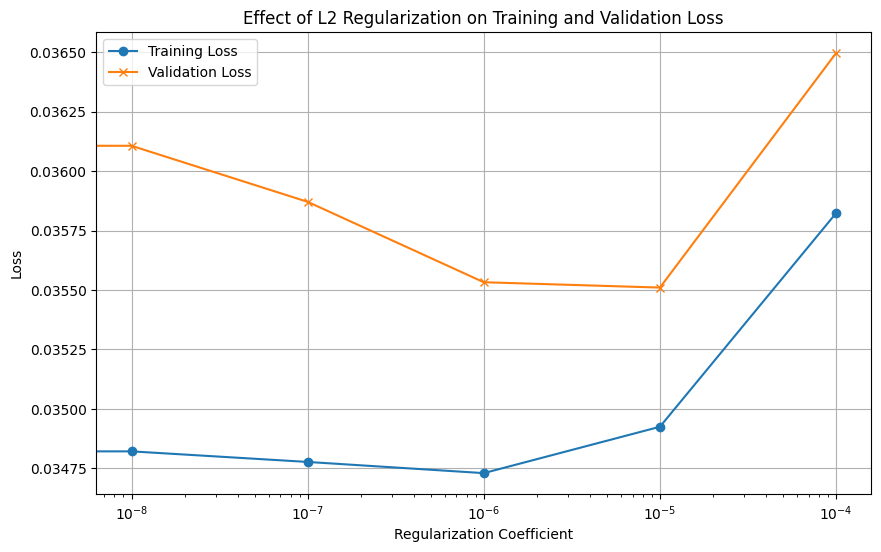

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


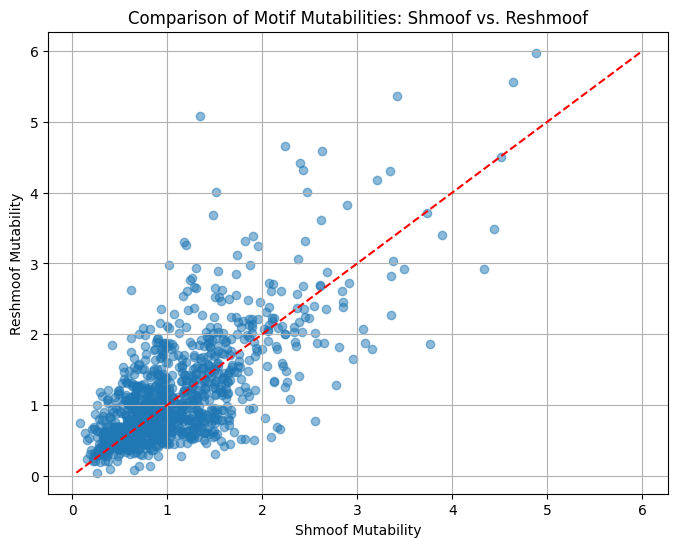

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

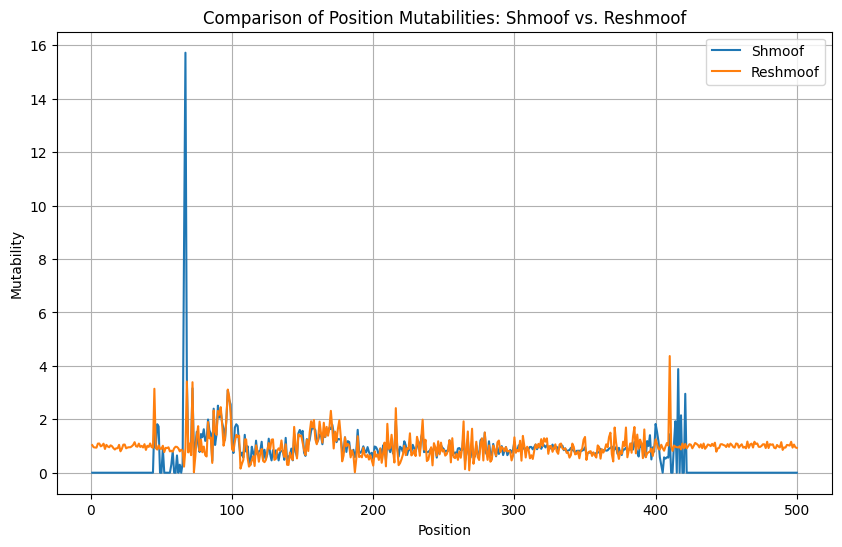

In [20]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()
